# LoRA 样例脚本

## 第一步：安装

安装 Data-Juicer 和 DiffSynth-Studio

In [1]:
!pip install simple-aesthetics-predictor

!pip install -v -e data-juicer

!pip uninstall pytorch-lightning -y
!pip install peft lightning pandas torchvision

!pip install -e DiffSynth-Studio

Looking in indexes: https://mirrors.aliyun.com/pypi/simple

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Using pip 23.0.1 from /usr/local/lib/python3.10/site-packages/pip (python 3.10)
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Obtaining file:///mnt/workspace/kolors/data-juicer
  Preparing metadata (setup.py) ...   Running command python setup.py egg_info
  /usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:55: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
    warnings.warn(
  running egg_info
  creating /tmp/pip-pip-egg-info-7jjt1xpm/py_data_juicer.egg-info
  writing /tmp/pip-pip-egg-info-7jjt1xpm/py_data_ju

# 请在这里手动重启 Notebook kernel

## 第二步：下载数据集

In [2]:
from modelscope.msdatasets import MsDataset

ds = MsDataset.load(
    'AI-ModelScope/lowres_anime',
    subset_name='default',
    split='train',
    cache_dir="/mnt/workspace/kolors/data"
)

保存数据集中的图片及元数据

In [3]:
import json, os
from data_juicer.utils.mm_utils import SpecialTokens
from tqdm import tqdm


os.makedirs("./data/lora_dataset/train", exist_ok=True)
os.makedirs("./data/data-juicer/input", exist_ok=True)
with open("./data/data-juicer/input/metadata.jsonl", "w") as f:
    for data_id, data in enumerate(tqdm(ds)):
        image = data["image"].convert("RGB")
        image.save(f"/mnt/workspace/kolors/data/lora_dataset/train/{data_id}.jpg")
        metadata = {"text": "二次元", "image": [f"/mnt/workspace/kolors/data/lora_dataset/train/{data_id}.jpg"]}
        f.write(json.dumps(metadata))
        f.write("\n")

100%|██████████| 1454/1454 [00:24<00:00, 58.17it/s] 


## 第三步：数据处理

使用 data-juicer 处理数据

In [4]:
data_juicer_config = """
# global parameters
project_name: 'data-process'
dataset_path: './data/data-juicer/input/metadata.jsonl'  # path to your dataset directory or file
np: 4  # number of subprocess to process your dataset

text_keys: 'text'
image_key: 'image'
image_special_token: '<__dj__image>'

export_path: './data/data-juicer/output/result.jsonl'

# process schedule
# a list of several process operators with their arguments
process:
    - image_shape_filter:
        min_width: 1024
        min_height: 1024
        any_or_all: any
    - image_aspect_ratio_filter:
        min_ratio: 0.5
        max_ratio: 2.0
        any_or_all: any
"""
with open("data/data-juicer/data_juicer_config.yaml", "w") as file:
    file.write(data_juicer_config.strip())

!dj-process --config data/data-juicer/data_juicer_config.yaml

2024-08-15 14:18:45.392515: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 14:18:46.206961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 14:18:47.647456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-15 14:18:48.673049: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://g

保存处理好的数据

In [5]:
import pandas as pd
import os, json
from PIL import Image
from tqdm import tqdm


texts, file_names = [], []
os.makedirs("./data/lora_dataset_processed/train", exist_ok=True)
with open("./data/data-juicer/output/result.jsonl", "r") as file:
    for data_id, data in enumerate(tqdm(file.readlines())):
        data = json.loads(data)
        text = data["text"]
        texts.append(text)
        image = Image.open(data["image"][0])
        image_path = f"./data/lora_dataset_processed/train/{data_id}.jpg"
        image.save(image_path)
        file_names.append(f"{data_id}.jpg")
data_frame = pd.DataFrame()
data_frame["file_name"] = file_names
data_frame["text"] = texts
data_frame.to_csv("./data/lora_dataset_processed/train/metadata.csv", index=False, encoding="utf-8-sig")
data_frame

100%|██████████| 129/129 [00:04<00:00, 31.88it/s]


file_name text
0       0.jpg  二次元
1       1.jpg  二次元
2       2.jpg  二次元
3       3.jpg  二次元
4       4.jpg  二次元
..        ...  ...
124   124.jpg  二次元
125   125.jpg  二次元
126   126.jpg  二次元
127   127.jpg  二次元
128   128.jpg  二次元

[129 rows x 2 columns]

## 第四步：训练模型

下载模型

In [6]:
from diffsynth import download_models

download_models(["Kolors", "SDXL-vae-fp16-fix"])

2024-08-15 14:19:06.427415: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 14:19:06.465639: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 14:19:07.171528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


    config.json has been already in models/kolors/Kolors/text_encoder.
    pytorch_model.bin.index.json has been already in models/kolors/Kolors/text_encoder.
    pytorch_model-00001-of-00007.bin has been already in models/kolors/Kolors/text_encoder.
    pytorch_model-00002-of-00007.bin has been already in models/kolors/Kolors/text_encoder.
    pytorch_model-00003-of-00007.bin has been already in models/kolors/Kolors/text_encoder.
    pytorch_model-00004-of-00007.bin has been already in models/kolors/Kolors/text_encoder.
    pytorch_model-00005-of-00007.bin has been already in models/kolors/Kolors/text_encoder.
    pytorch_model-00006-of-00007.bin has been already in models/kolors/Kolors/text_encoder.
    pytorch_model-00007-of-00007.bin has been already in models/kolors/Kolors/text_encoder.
    diffusion_pytorch_model.safetensors has been already in models/kolors/Kolors/unet.
    diffusion_pytorch_model.safetensors has been already in models/kolors/Kolors/vae.
    diffusion_pytorch_mo

['models/kolors/Kolors/text_encoder/config.json',
 'models/kolors/Kolors/text_encoder/pytorch_model.bin.index.json',
 'models/kolors/Kolors/text_encoder/pytorch_model-00001-of-00007.bin',
 'models/kolors/Kolors/text_encoder/pytorch_model-00002-of-00007.bin',
 'models/kolors/Kolors/text_encoder/pytorch_model-00003-of-00007.bin',
 'models/kolors/Kolors/text_encoder/pytorch_model-00004-of-00007.bin',
 'models/kolors/Kolors/text_encoder/pytorch_model-00005-of-00007.bin',
 'models/kolors/Kolors/text_encoder/pytorch_model-00006-of-00007.bin',
 'models/kolors/Kolors/text_encoder/pytorch_model-00007-of-00007.bin',
 'models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors',
 'models/kolors/Kolors/vae/diffusion_pytorch_model.safetensors',
 'models/sdxl-vae-fp16-fix/diffusion_pytorch_model.safetensors']

查看训练脚本的输入参数

In [7]:
!python DiffSynth-Studio/examples/train/kolors/train_kolors_lora.py -h

2024-08-15 14:19:10.700424: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 14:19:10.738310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 14:19:11.471702: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:55: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first,

开始训练

提示：

1. 在训练命令中填入 `--modelscope_model_id xxxxx` 以及 `--modelscope_access_token xxxxx` 后，训练程序会在结束时自动上传模型到 ModelScope
2. 部分参数可根据实际需求调整，例如 `lora_rank` 可以控制 LoRA 模型的参数量

In [8]:
import os

cmd = """
python DiffSynth-Studio/examples/train/kolors/train_kolors_lora.py \
  --pretrained_unet_path models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors \
  --pretrained_text_encoder_path models/kolors/Kolors/text_encoder \
  --pretrained_fp16_vae_path models/sdxl-vae-fp16-fix/diffusion_pytorch_model.safetensors \
  --lora_rank 32 \
  --lora_alpha 8.0 \
  --dataset_path data/lora_dataset_processed \
  --output_path ./models \
  --max_epochs 10 \
  --center_crop \
  --use_gradient_checkpointing \
  --precision "16-mixed"
""".strip()

os.system(cmd)

2024-08-15 14:19:18.032771: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 14:19:18.071208: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 14:19:18.794541: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:55: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first,

Loading models from: models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors
    model_name: sdxl_unet model_class: SDXLUNet
        This model is initialized with extra kwargs: {'is_kolors': True}
    The following models are loaded: ['sdxl_unet'].
Loading models from: models/kolors/Kolors/text_encoder


Loading checkpoint shards: 100%|██████████| 7/7 [01:09<00:00,  9.89s/it]


    The following models are loaded: ['kolors_text_encoder'].
Loading models from: models/sdxl-vae-fp16-fix/diffusion_pytorch_model.safetensors
    model_name: sdxl_vae_encoder model_class: SDXLVAEEncoder
        This model is initialized with extra kwargs: {'upcast_to_float32': True}
    model_name: sdxl_vae_decoder model_class: SDXLVAEDecoder
        This model is initialized with extra kwargs: {'upcast_to_float32': True}
    The following models are loaded: ['sdxl_vae_encoder', 'sdxl_vae_decoder'].
No sdxl_text_encoder models available.
No sdxl_text_encoder_2 models available.
Using kolors_text_encoder from models/kolors/Kolors/text_encoder.
Using sdxl_unet from models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors.
Using sdxl_vae_decoder from models/sdxl-vae-fp16-fix/diffusion_pytorch_model.safetensors.
Using sdxl_vae_encoder from models/sdxl-vae-fp16-fix/diffusion_pytorch_model.safetensors.
No sdxl_ipadapter models available.
No sdxl_ipadapter_clip_image_encoder models ava

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type              | Params | Mode
--------------------------------------------------
0 | pipe | SDXLImagePipeline | 9.0 B  | eval
--------------------------------------------------
46.4 M    Trainable params
8.9 B     Non-trainable params
9.0 B     Total params
35,812.581Total estimated model params size (MB)
6457      Modules in train mode
507       Modules in eval mode
/usr/local/lib/python3.10/site-packages/lightning/pytorch/tra

Epoch 9: 100%|██████████| 500/500 [09:04<00:00,  0.92it/s, v_num=1, train_loss=0.304]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 500/500 [09:05<00:00,  0.92it/s, v_num=1, train_loss=0.304]


0

In [17]:
import os

# 定义目录路径
directory = "./models/lightning_logs/version_1/checkpoints/"

# 检查目录是否存在
if os.path.exists(directory):
    # 遍历目录中的文件
    files = os.listdir(directory)
    
    # 如果目录中有文件，输出文件列表
    if files:
        print("以下是目录中的文件：")
        for file in files:
            print(file)
    else:
        print("目录中没有文件。")
else:
    print("目录不存在。")

以下是目录中的文件：
epoch=0-step=500.ckpt
epoch=3-step=2000.ckpt
epoch=8-step=4500.ckpt
epoch=2-step=1500.ckpt
epoch=5-step=3000.ckpt
epoch=1-step=1000.ckpt
epoch=6-step=3500.ckpt
epoch=7-step=4000.ckpt
epoch=4-step=2500.ckpt
epoch=9-step=5000.ckpt


加载模型

In [1]:
from diffsynth import ModelManager, SDXLImagePipeline
from peft import LoraConfig, inject_adapter_in_model
import torch


def load_lora(model, lora_rank, lora_alpha, lora_path):
    lora_config = LoraConfig(
        r=lora_rank,
        lora_alpha=lora_alpha,
        init_lora_weights="gaussian",
        target_modules=["to_q", "to_k", "to_v", "to_out"],
    )
    model = inject_adapter_in_model(lora_config, model)
    state_dict = torch.load(lora_path, map_location="cpu")
    model.load_state_dict(state_dict, strict=False)
    return model


# Load models
model_manager = ModelManager(torch_dtype=torch.float16, device="cuda",
                             file_path_list=[
                                 "models/kolors/Kolors/text_encoder",
                                 "models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors",
                                 "models/kolors/Kolors/vae/diffusion_pytorch_model.safetensors"
                             ])
pipe = SDXLImagePipeline.from_model_manager(model_manager)

# Load LoRA
pipe.unet = load_lora(
    pipe.unet,
    lora_rank=32, # This parameter should be consistent with that in your training script.
    lora_alpha=8.0, # lora_alpha can control the weight of LoRA.
    lora_path="models/lightning_logs/version_1/checkpoints/epoch=9-step=5000.ckpt"
)

2024-08-15 16:25:38.641287: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 16:25:38.679947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 16:25:40.048264: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/site-packages/_distutils_hack/__init__.py:55: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first,

Loading models from: models/kolors/Kolors/text_encoder


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

    The following models are loaded: ['kolors_text_encoder'].
Loading models from: models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors
    model_name: sdxl_unet model_class: SDXLUNet
        This model is initialized with extra kwargs: {'is_kolors': True}
    The following models are loaded: ['sdxl_unet'].
Loading models from: models/kolors/Kolors/vae/diffusion_pytorch_model.safetensors
    model_name: sdxl_vae_encoder model_class: SDXLVAEEncoder
        This model is initialized with extra kwargs: {'upcast_to_float32': True}
    model_name: sdxl_vae_decoder model_class: SDXLVAEDecoder
        This model is initialized with extra kwargs: {'upcast_to_float32': True}
    The following models are loaded: ['sdxl_vae_encoder', 'sdxl_vae_decoder'].
No sdxl_text_encoder models available.
No sdxl_text_encoder_2 models available.
Using kolors_text_encoder from models/kolors/Kolors/text_encoder.
Using sdxl_unet from models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors.
Using s

生成图像

In [13]:
torch.manual_seed(0)
image = pipe(
    prompt="古风，水墨画，一个黑色长发少女，坐在古代书院的教室里，认真听讲，盯着老师手中的竹简，上半身，绿色长裙，背景有木质桌椅和古书架",
    negative_prompt="现代风格，数字画，丑陋、变形、嘈杂、模糊、低对比度，扭曲的手指，多余的手指",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("1.jpg")

100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 

In [ ]:
torch.manual_seed(1)
image = pipe(
    prompt="古风，水墨画，一个黑色长发少女，伏在书桌上，眼睛半闭，显露出疲惫感，上半身，绿色长裙，周围书籍散乱，窗外夕阳透进来",
    negative_prompt="现代风格，数字画，丑陋、变形、嘈杂、模糊、低对比度，扭曲的手指，多余的手指",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("2.jpg")

In [ ]:
torch.manual_seed(2)
image = pipe(
    prompt="古风，水墨画，一个黑色长发少女，站在一条青石板小路旁，四周桃花盛开，全身，白色飘逸长裙，背景是远处的古风建筑，天空中有几朵淡云",
    negative_prompt="现代风格，数字画，丑陋、变形、嘈杂、模糊、低对比度，扭曲的手指，多余的手指",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("3.jpg")

In [ ]:
torch.manual_seed(3)
image = pipe(
    prompt="古风，水墨画，一位身穿银色盔甲的年轻王子，骑着一匹白色骏马从远处走来，手持长剑，全身，背景为古风山野，桃花纷飞",
    negative_prompt="现代风格，数字画，丑陋、变形、嘈杂、模糊、低对比度，扭曲的手指，多余的手指",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("4.jpg")

In [ ]:
torch.manual_seed(0)
image = pipe(
    prompt="古风，水墨画，黑色长发少女与身穿银甲的王子站在路旁，微笑交谈，彼此注视，上半身，少女着白色长裙，王子手持缰绳，背景为桃花盛开的古风小路",
    negative_prompt="现代风格，数字画，丑陋、变形、嘈杂、模糊、低对比度，扭曲的手指，多余的手指",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("5.jpg")

In [ ]:
torch.manual_seed(1)
image = pipe(
    prompt="古风，水墨画，黑色长发少女与王子共骑一匹白马，少女侧坐在马背上，双手环抱王子的腰，全身，少女穿白色长裙，王子穿银甲，背景为青山绿水",
    negative_prompt="现代风格，数字画，丑陋、变形、嘈杂、模糊、低对比度，扭曲的手指，多余的手指",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("6.jpg")

In [ ]:
torch.manual_seed(7)
image = pipe(
    prompt="古风，水墨画，黑色长发少女从书桌上抬起头，眼神迷茫刚从梦中醒来，上半身，绿色长裙，书桌上的竹简散乱，窗外阳光明媚",
    negative_prompt="现代风格，数字画，丑陋、变形、嘈杂、模糊、低对比度，扭曲的手指，多余的手指",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("7.jpg")

In [ ]:
torch.manual_seed(7)
image = pipe(
    prompt="古风，水墨画，黑色长发少女站在教室中，手握毛笔在书案上认真书写，全身，绿色长裙，背景为书院的木质书架和摆满书籍的桌子",
    negative_prompt="现代风格，数字画，丑陋、变形、嘈杂、模糊、低对比度，扭曲的手指，多余的手指",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("8.jpg")

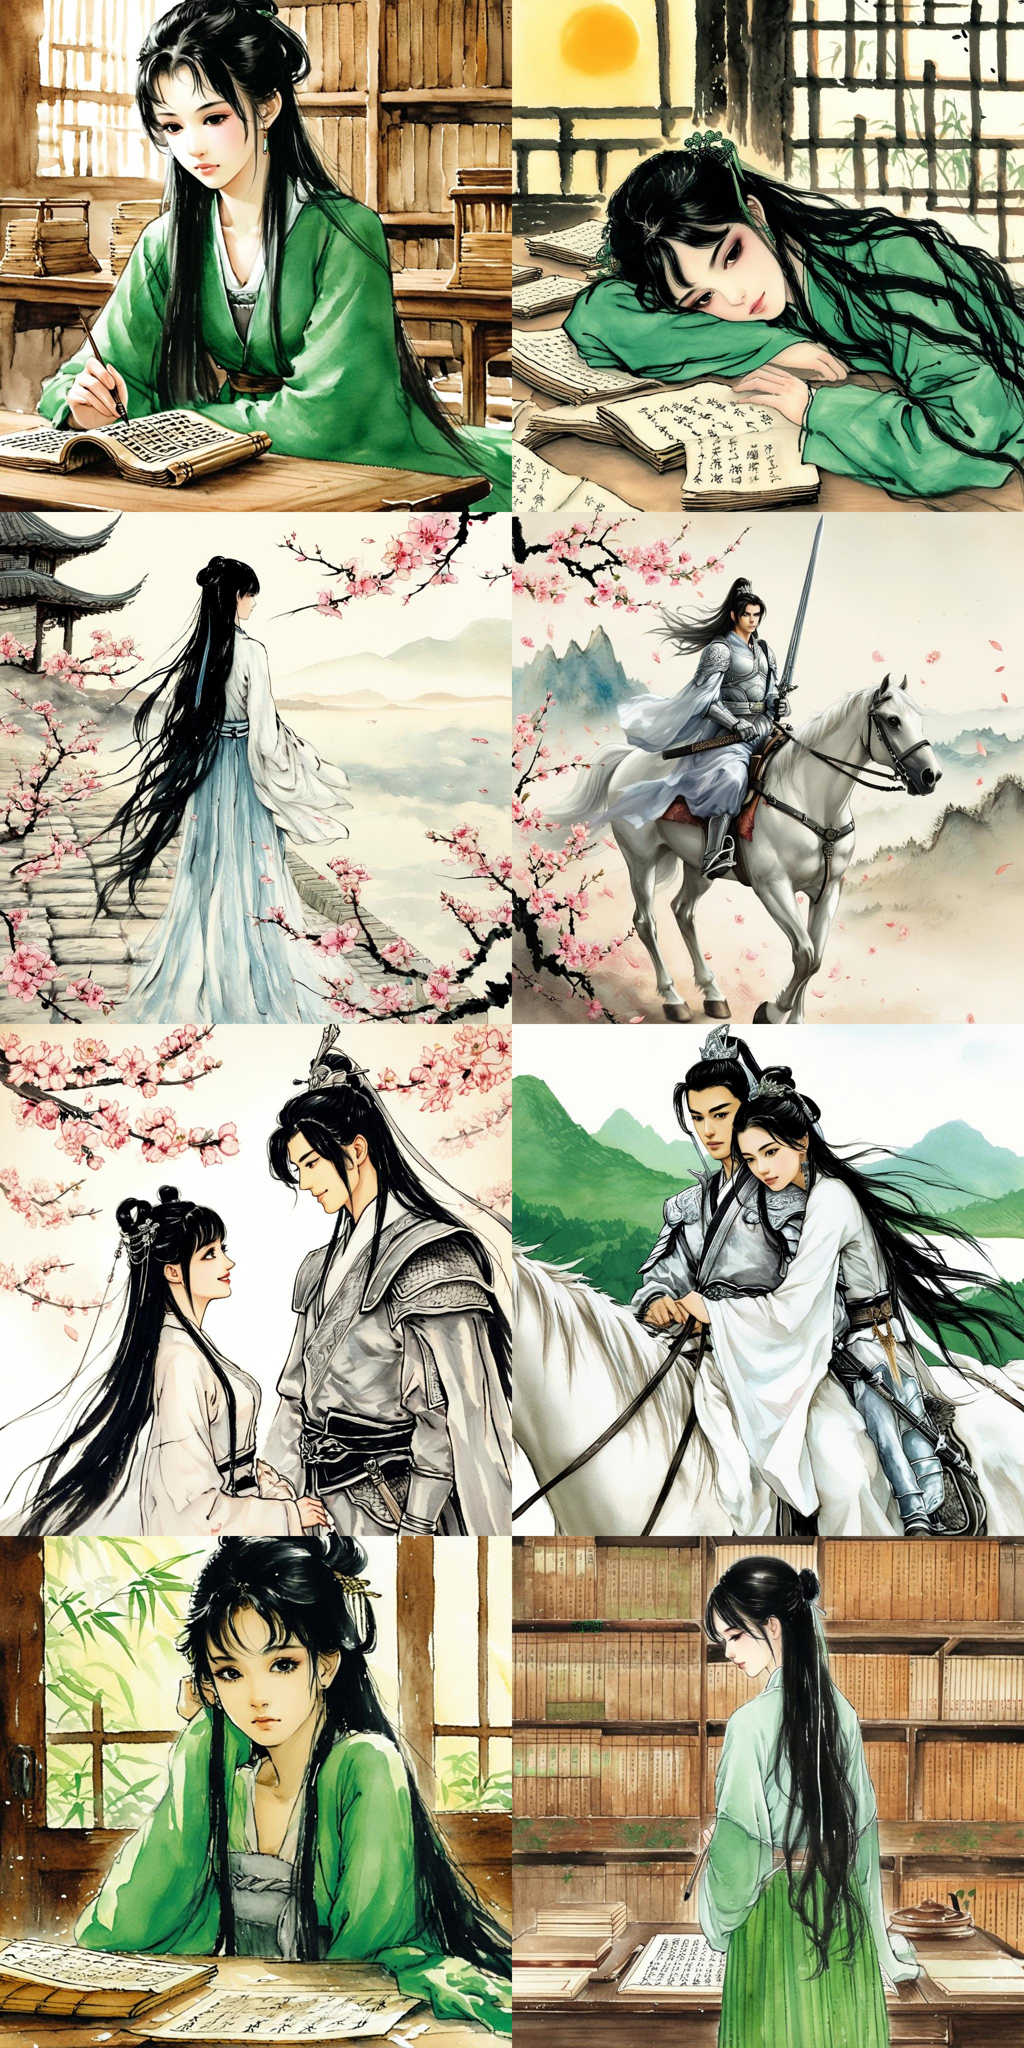

In [10]:
import numpy as np
from PIL import Image


images = [np.array(Image.open(f"{i}.jpg")) for i in range(1, 9)]
image = np.concatenate([
    np.concatenate(images[0:2], axis=1),
    np.concatenate(images[2:4], axis=1),
    np.concatenate(images[4:6], axis=1),
    np.concatenate(images[6:8], axis=1),
], axis=0)
image = Image.fromarray(image).resize((1024, 2048))
image

In [ ]:
!pip install simple-aesthetics-predictor

In [11]:
import os

# 设置目录路径
directory = './images'

# 遍历目录中的所有文件
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # 删除文件或链接
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # 删除文件夹
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

print("所有文件已清理完毕！")

Failed to delete ./images/.ipynb_checkpoints. Reason: name 'shutil' is not defined
所有文件已清理完毕！


In [12]:
import torch, os
from PIL import Image
from transformers import CLIPProcessor
from aesthetics_predictor import AestheticsPredictorV2Linear
from modelscope import snapshot_download


model_id = snapshot_download('AI-ModelScope/aesthetics-predictor-v2-sac-logos-ava1-l14-linearMSE', cache_dir="models/")
predictor = AestheticsPredictorV2Linear.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
device = "cuda"
predictor = predictor.to(device)


def get_aesthetics_score(image):
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = predictor(**inputs)
    prediction = outputs.logits
    return prediction.tolist()[0][0]


def evaluate(folder):
    scores = []
    for file_name in os.listdir(folder):
        if os.path.isfile(os.path.join(folder, file_name)):
            image = Image.open(os.path.join(folder, file_name))
            scores.append(get_aesthetics_score(image))
    if len(scores) == 0:
        return 0
    else:
        return sum(scores) / len(scores)


score = evaluate("./images")
print(score)

6.39781928062439
